# Import Libraries

In [6]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the data

In [7]:
df = pd.read_csv("../data/processed/youtube_combined_data.csv")
print(f"Data loaded with shape: {df.shape}")

%run "./02_data_cleaning.ipynb"
%run "./03_feature_engineering.ipynb"

df = clean_data(df)
df = feature_engineering(df)
df = drop_unused_columns(df)

print(f"Data after preprocessing has shape: {df.shape}")


Data loaded with shape: (50160, 16)
Data after preprocessing has shape: (49229, 17)


In [ ]:
# Define target and feature lists

target = 'engagement_rate_log'

categorical_features = ['category_id', 'captions_flag']

numeric_features = [
    'total_videos','channel_age_days','title_length','title_words',
    'title_exclamation','title_question',
    'duration_minutes','publish_hour_sin','publish_hour_cos',
    'publish_dow_sin','publish_dow_cos',
    'subscriber_count_log','is_hd'
]

all_features = categorical_features + numeric_features

X = df[all_features].copy()
y = df[target].copy()
groups = df['channel_id']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [10]:
train_means = y_train.groupby(X_train['category_id']).mean()

X_train['category_te'] = X_train['category_id'].map(train_means)
X_test['category_te']  = X_test['category_id'].map(train_means)

numeric_features.append('category_te')


In [ ]:
# Clipping of numeric features

def robust_clip(train_col, test_col):
    q_low = train_col.quantile(0.01)
    q_high = train_col.quantile(0.99)

    Q1, Q3 = train_col.quantile(0.25), train_col.quantile(0.75)
    IQR = Q3 - Q1

    lower = max(q_low, Q1 - 1.5 * IQR)
    upper = min(q_high, Q3 + 1.5 * IQR)

    return train_col.clip(lower, upper), test_col.clip(lower, upper)


for col in ['total_videos', 'channel_age_days']:
    X_train[col], X_test[col] = robust_clip(X_train[col], X_test[col])


# Model Fit

In [12]:
model = CatBoostRegressor(
    depth=6,
    learning_rate=0.03,
    iterations=1500,
    l2_leaf_reg=10,
    subsample=0.8,

    loss_function='RMSE',
    cat_features=categorical_features,
    random_seed=42,
    early_stopping_rounds=150,
    verbose=200
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test)
)


0:	learn: 0.2417744	test: 0.2446141	best: 0.2446141 (0)	total: 207ms	remaining: 5m 10s
200:	learn: 0.1992377	test: 0.2124231	best: 0.2124231 (200)	total: 15.9s	remaining: 1m 42s
400:	learn: 0.1936147	test: 0.2104923	best: 0.2104835 (397)	total: 29.7s	remaining: 1m 21s
600:	learn: 0.1894601	test: 0.2098588	best: 0.2098158 (596)	total: 44.4s	remaining: 1m 6s
800:	learn: 0.1862162	test: 0.2091354	best: 0.2091293 (798)	total: 58s	remaining: 50.6s
1000:	learn: 0.1839456	test: 0.2083284	best: 0.2083202 (997)	total: 1m 13s	remaining: 36.5s
1200:	learn: 0.1818250	test: 0.2076357	best: 0.2076320 (1199)	total: 1m 27s	remaining: 21.7s
1400:	learn: 0.1798508	test: 0.2069196	best: 0.2069057 (1399)	total: 1m 42s	remaining: 7.21s
1499:	learn: 0.1788727	test: 0.2066575	best: 0.2066525 (1498)	total: 1m 50s	remaining: 0us

bestTest = 0.2066525309
bestIteration = 1498

Shrink model to first 1499 iterations.


# Evaluation

In [13]:
y_pred = model.predict(X_test)

print("\n TEST PERFORMANCE ")
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

y_train_pred = model.predict(X_train)

print("\n TRAIN PERFORMANCE ")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Train R2:", r2_score(y_train, y_train_pred))



 TEST PERFORMANCE 
Test MAE: 0.151116189499048
Test RMSE: 0.20665253129874223
Test R2: 0.2938286560260873

 TRAIN PERFORMANCE 
Train RMSE: 0.17893598846544045
Train MAE: 0.12883631182408062
Train R2: 0.4583760618457857


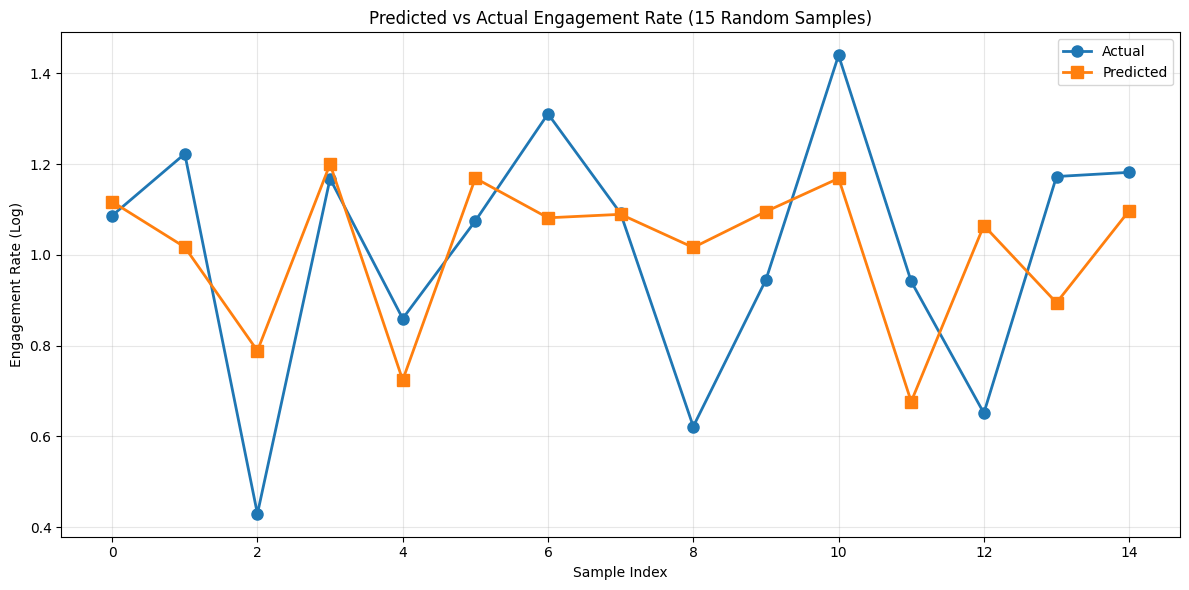

In [14]:
import matplotlib.pyplot as plt

# Select random 15 indices from test set
random_indices = np.random.choice(len(y_test), 15, replace=False)
random_indices = sorted(random_indices)

# Get actual and predicted values
actual_values = y_test.iloc[random_indices].values
predicted_values = y_pred[random_indices]

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(range(15), actual_values, marker='o', label='Actual', linewidth=2, markersize=8)
plt.plot(range(15), predicted_values, marker='s', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate (Log)')
plt.title('Predicted vs Actual Engagement Rate (15 Random Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()